# Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading and Cleaning

In [2]:
vandy = pd.read_csv("/home/lodhar/afib-dl/data/activated_vandy.csv").drop(['Unnamed: 0', 'nifti_dir'], axis = 1)

## Add Activations

In [3]:
def convert_to_array(string_repr):
    cleaned_string = string_repr.replace("[[", "").replace("]]", "").replace("\n", "")
    return np.fromstring(cleaned_string, sep=' ')

vandy['activations'] = vandy['activations'].apply(convert_to_array)

/tmp/ipykernel_2457216/1933851363.py:3: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(cleaned_string, sep=' ')


In [4]:
vandy['activations_shape'] = vandy['activations'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)
vandy = vandy[vandy['activations_shape'] == (512,)].drop(['activations_shape'], axis = 1)
flattened_activations = np.array(vandy['activations'].tolist()).reshape(-1, 512)
activations_df = pd.DataFrame(flattened_activations, columns=[f'activation_{i}' for i in range(512)])

## Data Processing

In [5]:
from sklearn.preprocessing import OneHotEncoder

outcomes = [col for col in vandy.columns if 'recur' in col.lower()]
valve_dx_cols = [col for col in vandy.columns if 'type_valve_dx' in col.lower()]
ablation_cols = [col for col in vandy.columns if 'ablation' in col.lower()]
    
vandy = vandy.drop(valve_dx_cols + ablation_cols, axis = 1).drop(['study_id', 'mri_ct', 'date_of_recur', 'time_to_recur', 'activations'], axis = 1)

def one_hot_encode(original_dataframe, feature_to_encode):
    original_dataframe[feature_to_encode] = original_dataframe[feature_to_encode].astype(str)
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_one_hot_encode = ['race', 'ethnicity']
for feature in features_to_one_hot_encode:
    vandy = one_hot_encode(vandy, feature)

features_to_binarize = vandy.select_dtypes('int64').columns
vandy

,gender,pt_height,weight,htn,diabetes,chf,cad,stroke_tia,osa,creatinine,...,recurrence,cont_monitor,is_training,race_1,race_2,race_4,race_6,ethnicity_0,ethnicity_1,ethnicity_2
0,1,182.9,88.30,1,0,1,0,1,0,0.82,...,0,1,False,False,False,True,False,False,True,False
1,0,175.3,112.90,1,1,0,0,0,0,0.89,...,0,0,False,False,False,True,False,False,True,False
2,1,179.1,110.22,1,0,0,1,0,0,0.78,...,0,1,False,False,False,True,False,False,True,False
3,0,165.0,145.00,1,0,0,0,0,1,0.76,...,0,0,True,False,False,True,False,False,True,False
4,1,183.0,86.00,0,0,0,0,0,0,1.04,...,0,0,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1,175.0,75.00,1,1,1,1,0,0,1.80,...,1,1,False,False,False,True,False,False,True,False
419,1,180.3,127.00,1,0,0,0,0,1,0.82,...,1,0,False,False,False,True,False,False,True,False
420,0,160.0,120.00,1,0,0,0,0,0,0.83,...,1,0,True,False,False,True,False,False,True,False
421,1,175.0,115.00,1,1,0,0,0,1,1.51,...,1,1,True,False,False,True,False,False,True,False


# Optimizing Activations DF

In [6]:
correlation_matrix = activations_df.corr()

redundant_columns = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Adjust the threshold as needed
            #redundant_columns.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
            redundant_columns.append(correlation_matrix.columns[j])

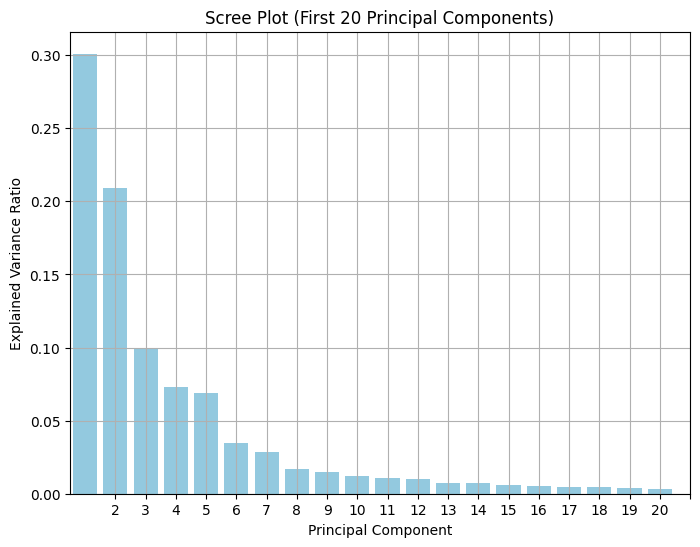

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming activations_df is your DataFrame with activations

# Perform PCA directly on the original data
pca = PCA()
pca.fit(activations_df)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_[:20]  # Slice to include only the first 20 elements

# Plot the scree plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(1, len(explained_variance_ratio) + 1), y=explained_variance_ratio, color='skyblue')
plt.title('Scree Plot (First 20 Principal Components)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

## ML-based Feature Selection

In [7]:
activations_model = pd.concat([activations_df, vandy.reset_index(drop = True)[['is_training', 'recurrence']]], axis = 1)
train = activations_model[activations_model['is_training']].drop(['is_training'], axis = 1).reset_index(drop=True)
test = activations_model[~activations_model['is_training']].drop(['is_training'], axis = 1).reset_index(drop=True)
X_train = train.drop(['recurrence'], axis = 1)
y_train = train['recurrence']
X_test = test.drop(['recurrence'], axis = 1)
y_test = test['recurrence']

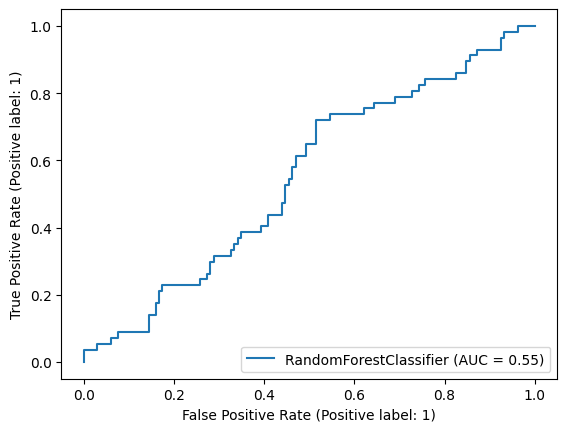

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [1, 20, 100],
    'max_features': ['log2'],
    'max_depth' : [3,5,7],
    'criterion' :['entropy']
}
rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 5)
rfc.fit(X_train, y_train)
RocCurveDisplay.from_estimator(rfc.best_estimator_, X_test, y_test)

In [ ]:
importances = forest.feature_importances_

In [ ]:
import xgboost as xgb

#dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
#dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Train a model using the scikit-learn API
xgb_classifier = xgb.XGBClassifier(n_estimators=100, 
                                   objective='binary:logistic', 
                                   tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

# Convert the model to a native API model
model = xgb_classifier.get_booster()

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(xgb_classifier, X_test, y_test)
#xgb_classifier.predict(X_test)

# Modeling

## Preprocessing

In [ ]:
# PICK ONE
model_matrix = pd.concat([vandy.reset_index(drop = True), activations_df], axis = 1)
model_matrix = model_matrix.drop(redundant_columns, axis = 1)

In [ ]:
#model_matrix = vandy.reset_index(drop = True) #purely clinical classifier

## Test-Train Split

In [ ]:
train = model_matrix[model_matrix['is_training']].drop(['is_training'], axis = 1).reset_index(drop=True)
test = model_matrix[~model_matrix['is_training']].drop(['is_training'], axis = 1).reset_index(drop=True)
X_train = train.drop(['recurrence'], axis = 1)
y_train = train['recurrence']
X_test = test.drop(['recurrence'], axis = 1)
y_test = test['recurrence']

## KNN

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


for column in X_test.columns:
    for idx, value in X_test[column].items():
        try:
            float(value)
        except ValueError:
            print(f"Row index: {idx}, Column: {column}, Value: {value}")

In [ ]:
clinical_cols = [col for col in X_train.columns if 'activation' not in col]
scaler = StandardScaler()
scaler.fit(X_train[clinical_cols])
X_train[clinical_cols] = scaler.fit_transform(X_train[clinical_cols])
X_test[clinical_cols] = scaler.transform(X_test[clinical_cols])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay

knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=list(range(1, min(X_test.shape[0], X_train.shape[0])//2)))
grid = GridSearchCV(knn, param_grid, cv=10, scoring = 'roc_auc', return_train_score=False)
knn = grid.fit(X_train, y_train)

RocCurveDisplay.from_estimator(knn.best_estimator_, X_test, y_test)